In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime
import json
from pickle import dump,load
from data_util import prepare_data, plot_weekly
from model_util import create_model_attention, attention
from keras.models import load_model
from pickle import load

plt.interactive(True)
pd.options.plotting.backend='plotly'

current_time = datetime.datetime.now()
time = current_time.strftime("%Y-%m-%d %H:%M:%S%z") #"%Y%m%d_%H%M" impianto

with open(model_opt['model_path'] + 'Errors.csv', 'w') as f:
    f.write('units,input_dim,mae')

2023-08-03 18:49:47.004185: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-03 18:49:47.007295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-03 18:49:47.007305: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Options

- hour-ahead!

In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)

path = "./Output/Trial_" + time

sito = 'JPL'         #'impianto4'

file_opt = {
    'file': sito,
    'directory_file': "./dati/",
    'dt_format': "%d/%m/%Y %H:%M",
    'to_timezone': 'America/Los_Angeles'}   #Europe/Rome

manage_file = {
    'filtra_by_date': True,  # per restituire una porzione di df - insieme a inizio_filtro fine_filtro
    'aggregate_w_we': 'by_day',  # 'grouped' # by_day --> se grouped 0,1 su colonna week_day
    'only_week_weekend': False,  # 'week',  # 'week',  # week weekend False
    'single_day': False,  # 'monday'# False # 'tuesday'
    'remove_nan_ID': False,  # remove session when user ID is not given
    'togli_durata_inferiore': False,  # se durata sessione inferiore a {minuti} --> rimuovi
}
# scaled = values
# specify the number of lag hours
data_opt = {
    #'reload_data': False,
    'n_back': 4*24*3,  # 4*24*7
    'n_timesteps': int(4*24*1.5),  # 96
    'lag': 0,
    'dataset_split': 'data', # 'percentage', data
    'tr_per': 0.90,
    #'training_test_split_data': '30/05/2023 00:15',
    'out_col': ['power'],      #Potenza
    'features': []#['year', 'month', 'day', 'hour', 'minute'],
}

data_opt['columns'] = data_opt['features'] + data_opt['out_col']
data_opt['n_features'] = len(data_opt['columns'])

model_opt = {'LSTM_num_hidden_units': [24],
             #'LSTM_layers': 1,
             'input_dim': (data_opt['n_back'], data_opt['n_features']),
             'dense_out': data_opt['n_timesteps'],
             'neurons_activation': 'relu',
             'metrics': 'mse',
             'optimizer': 'adam',
             'patience': 5,
             'epochs': 50,
             'validation_split': 0.2,
             'model_path': './Output/',
             'Dropout_rate': 0.2,
             }

# Data

## Import

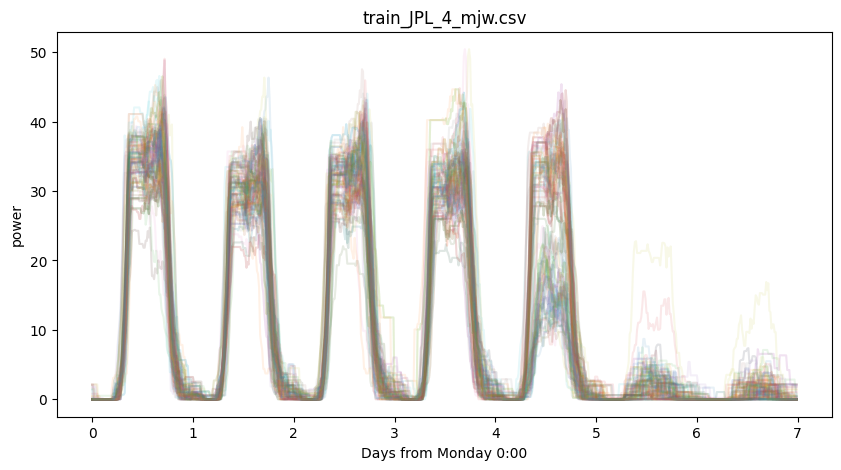

In [3]:
filename = 'train_JPL_4_mjw.csv'

dataset = pd.read_csv('dati/'+filename,index_col=0,parse_dates=True)

# dataset = pd.read_csv('dati/'+filename,sep=';')
# dataset['times_utc'] = pd.to_datetime(dataset['times_utc'], format=file_opt['dt_format'])
# dataset.set_index('times_utc', inplace=True)


dataset = dataset.resample('15min').mean()
plot_weekly(dataset.power,title=filename,alpha=0.1)

## Clean (optional)

The second block is run once for each month in the dataset to visually see outliers. 

Turn on plotly (first cell up top) to easily find the day-of-month to be replaced.

In [4]:
# year_month = '2020'

# plot_weekly(dataset.loc[year_month].power,alpha=0.3,begin_on_monday=False)
# dataset['weekday'] = dataset.index.weekday*10
# dataset[['weekday','power']].loc[year_month].plot()

In [5]:
# dataset.loc['2020-12-7':'2020-12-8']  = dataset.loc['2020-11-30':'2020-12-1'].values
# dataset.loc['2021-10-11':'2021-10-15']  = dataset.loc['2021-10-4':'2021-10-8'].values
# dataset.loc['2022-5-23':'2022-5-24']  = dataset.loc['2022-5-16':'2022-5-17'].values
# dataset.loc['2022-9-5':'2022-9-6']  = dataset.loc['2022-8-29':'2022-8-30'].values
# dataset.loc['2023-12-19':'2023-12-22']  = dataset.loc['2023-12-12':'2023-12-15'].values
# dataset.loc['2023-11-20']  = dataset.loc['2023-11-13'].values

# plot_weekly(dataset.power,title='train_JPL_4_mjw.csv Cleaned')
# dataset.to_csv('dati/train_JPL_4_mjw.csv')

## Shape

In [6]:
dataset['year'] = dataset.index.year
dataset['month'] = dataset.index.month
dataset['day'] = dataset.index.dayofweek
dataset['hour'] = dataset.index.hour
dataset['minute'] = dataset.index.minute

dataset = dataset[data_opt['columns']]

# print('data loaded')
train_X, train_y, test_X, test_y, scaler_X, scaler_y  = prepare_data(dataset, data_opt)
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1)) #solo ENC-DEC
# a = np.load('dati_veicoli/train_X.npy')

In [7]:
dump(scaler_X, open(model_opt["model_path"] + "scaler_in.pkl", 'wb'))
dump(scaler_y, open(model_opt["model_path"] + "scaler_out.pkl", 'wb'))

# Model

## Build

In [8]:
# smltn_chr = 'forecast'

with open(model_opt['model_path'] + 'Param.txt', 'w') as convert_file:
    convert_file.write(json.dumps(data_opt))
    convert_file.write(json.dumps(model_opt))

## Train

2023-08-03 18:49:48.880772: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-03 18:49:48.880795: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-03 18:49:48.880810: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (atium): /proc/driver/nvidia/version does not exist
2023-08-03 18:49:48.881019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 1)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 288, 24),    2496        ['input_1[0][0]']                
                                 (None, 24),                                                      
                                 (None, 24)]                                                      
                                                                                                  
 attention (attention)          (None, 24)           312         ['lstm[0][0]']                   
                                                                                              

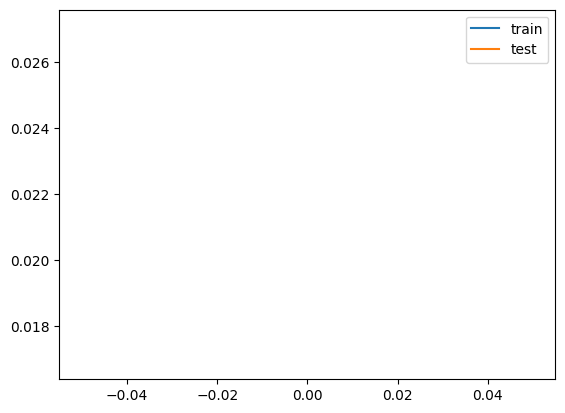

In [9]:
model_create_load_tune= 'create' # tune , load
if model_create_load_tune == 'create':
    model, history = create_model_attention(model_opt, train_X, train_y)
    model.save(model_opt['model_path'] + 'model.h5')

    # plot history
    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.savefig(model_opt['model_path'] + 'history.png')

# Analyze

## Load

In [10]:
scaler_X = load(open(model_opt["model_path"] + "scaler_in.pkl", 'rb')) 
scaler_y = load(open(model_opt["model_path"] + "scaler_out.pkl", 'rb'))

model = load_model(model_opt["model_path"] + 'model.h5', custom_objects={"attention": attention})

## Predict

In [11]:
# make a prediction
yhat_np = model.predict(test_X)
yhat_np = yhat_np.reshape((yhat_np.shape[0], yhat_np.shape[1]))

# invert scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat_np)

y_hat = pd.DataFrame(data=inv_yhat, columns=test_y.columns, index=test_y.index)

256/256 [==============================] - 6s 21ms/step


In [12]:
# save
y_hat.to_csv(f"{model_opt['model_path']}forecast.csv")
test_y.to_csv(f"{model_opt['model_path']}measures.csv")

In [21]:
with open(model_opt['model_path'] + 'Errors.csv', 'a') as f:
    mae = (abs(y_hat.values - test_y.values)).mean()
    units = model_opt['LSTM_num_hidden_units'][0]
    input_dim = model_opt['input_dim']
    f.write(f'{mae},{input_dim},{mae}'

# Plot

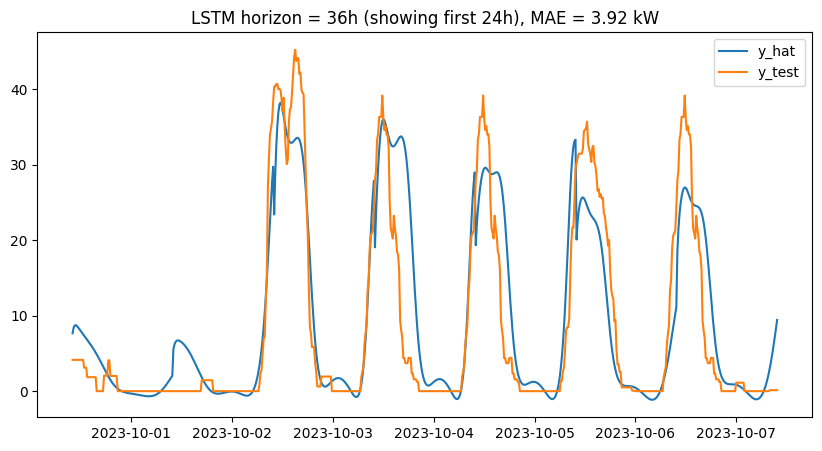

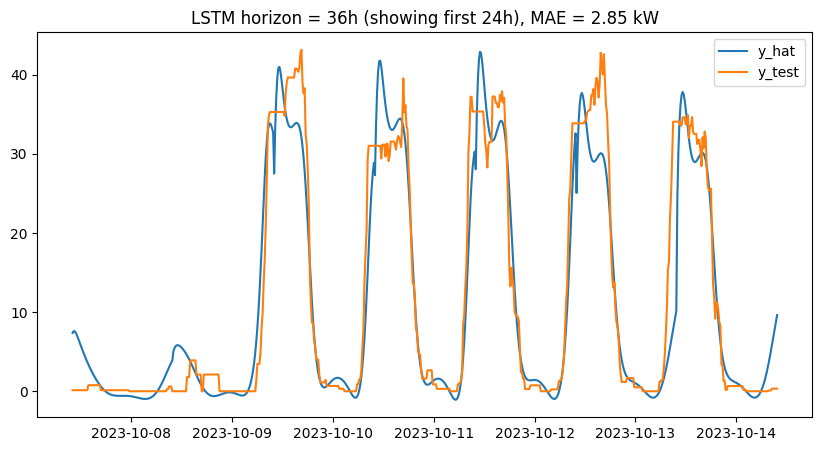

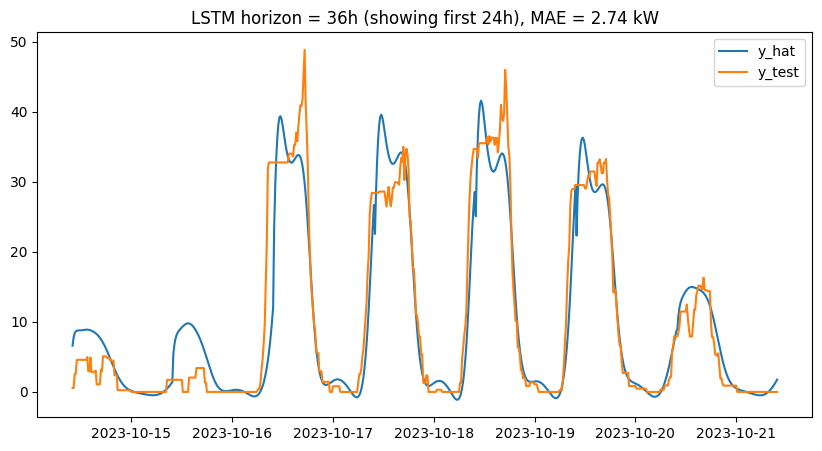

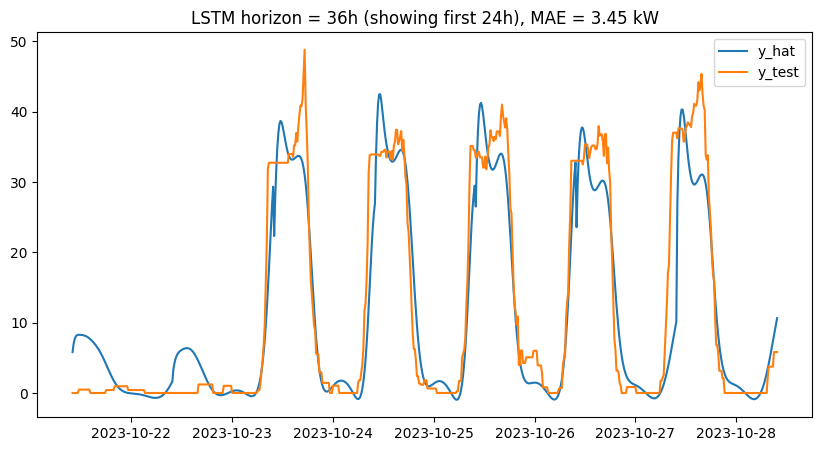

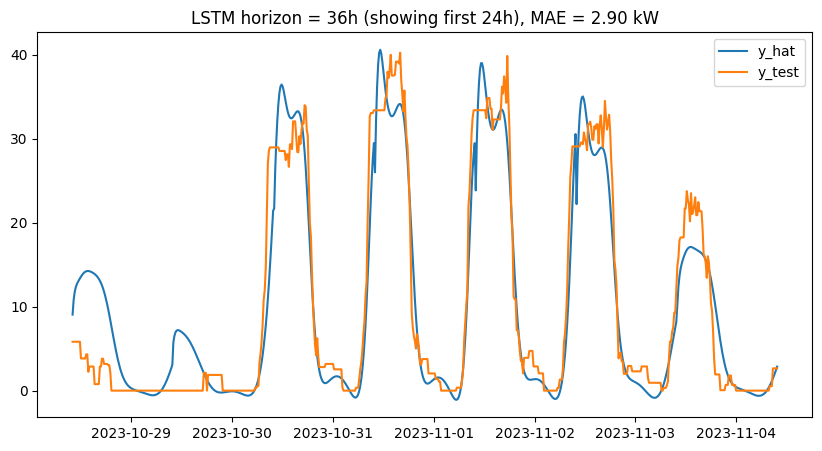

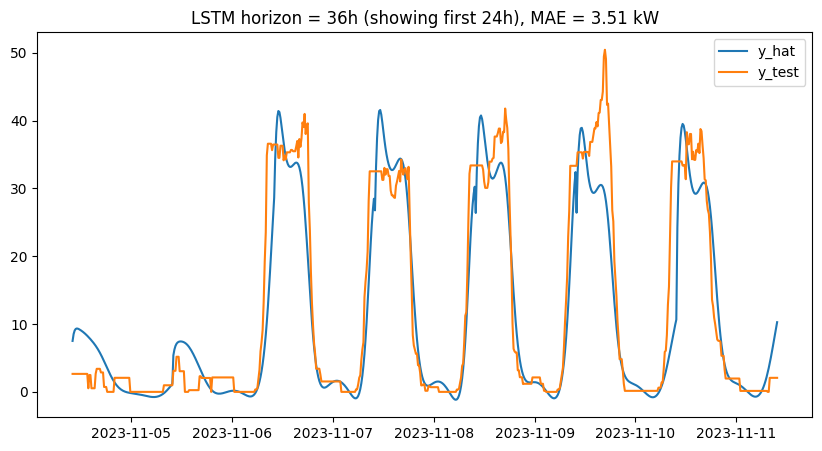

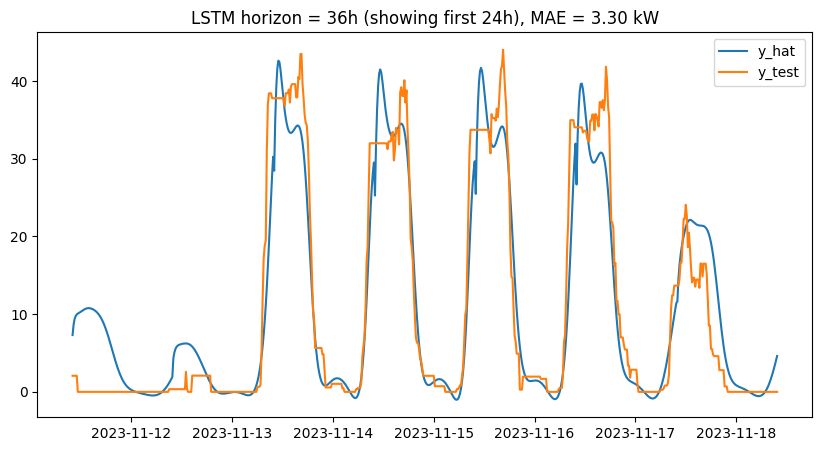

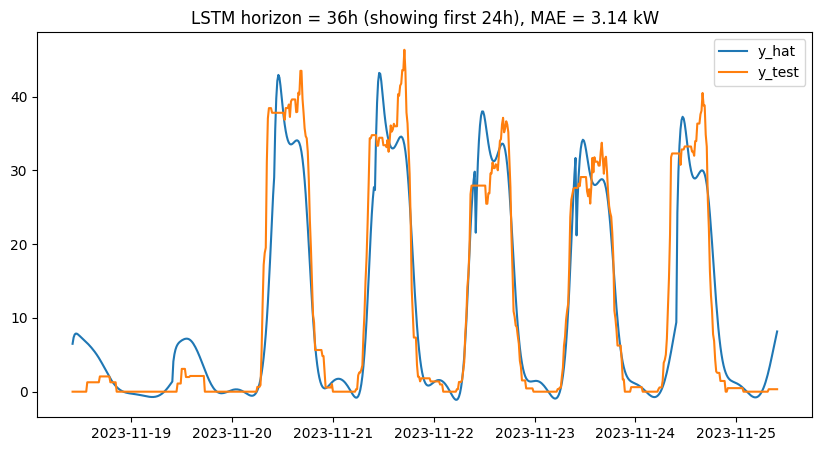

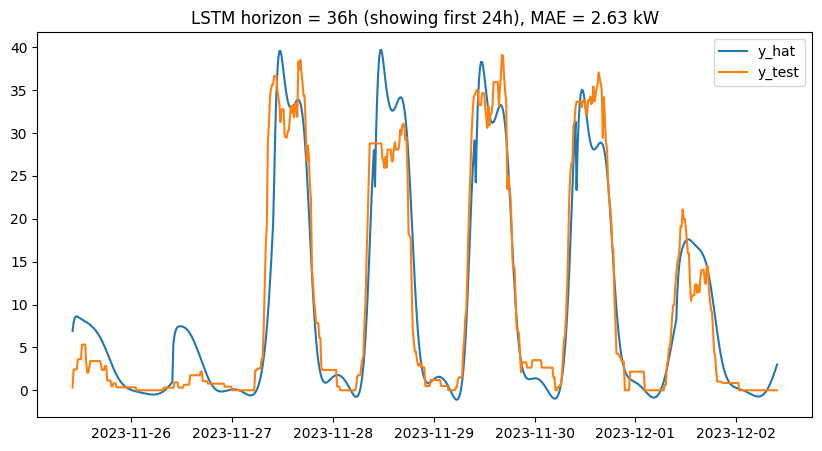

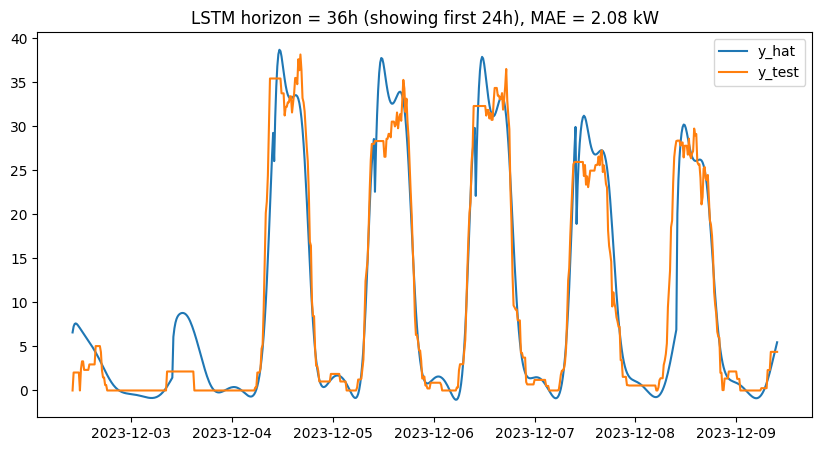

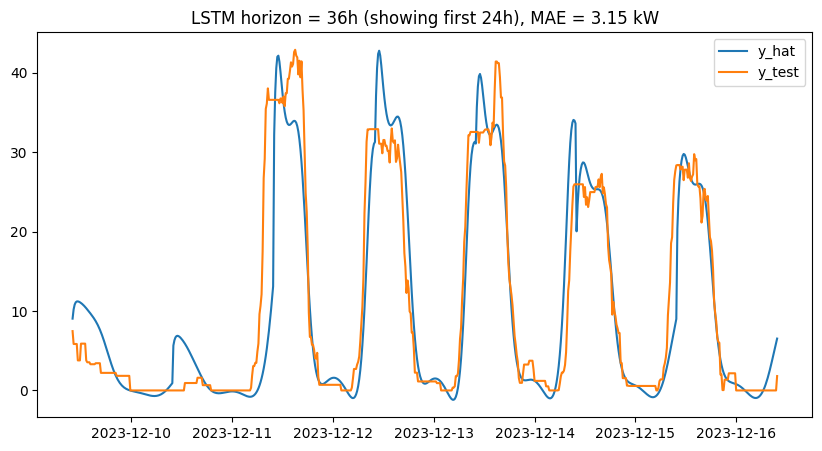

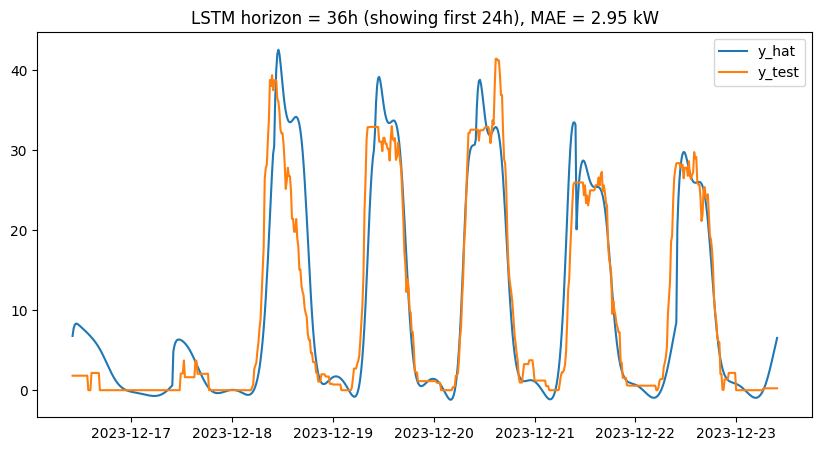

In [13]:
viz_horizon_h = 24
horizon_h = int(data_opt['n_timesteps']/4)

week = 0
while ((1+week)*672) < len(y_hat):
    idx = pd.date_range(y_hat.index[week*672],
                            periods=int(168/viz_horizon_h),
                            freq=f'{viz_horizon_h}h')

    out1_tplus = [f'out1(t+{t})' for t in range(4*viz_horizon_h)]

    y_hat_flat =   y_hat[out1_tplus].loc[idx].values.flatten()
    test_y_flat = test_y[out1_tplus].loc[idx].values.flatten()

    mae = (((y_hat_flat - test_y_flat)**2)**(0.5)).mean()

    t = pd.date_range(idx[0],periods=len(y_hat_flat),freq='15min')
    plt.figure(figsize=(10,5))
    plt.plot(t,y_hat_flat,label='y_hat')
    plt.plot(t,test_y_flat,label='y_test')
    plt.legend()
    plt.title(f'LSTM horizon = {horizon_h}h (showing first {viz_horizon_h}h), MAE = {mae:.2f} kW')
    plt.savefig(f'Output/test_vs_predict_week{week}.png')

    week+=1